# Sklearn Workshop 2: Mobile Price Prediction (Classificaiton)


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
#the difficult one.....
# fc:Front Camera mega pixels
# int_memory:Internal Memory in Gigabytes
# m_dep:Mobile Depth in cm
# pc:Primary Camera mega pixels
# sc_h:Screen Height of mobile in cm
# sc_w:Screen Width of mobile in cm
# talk_time:longest time that a single battery charge will last when you are

### Step 1: ETL

In [34]:
#just consider this as a mix of train and test.....
#don't use the testing set because it does not have target (so we cannot interpret.....)
df = pd.read_csv("data/train_mobile.csv")

In [44]:
# df.describe()  #no missing values, seems like....
# df.dtypes
# df['price_range'].value_counts()  #check whether data class is balanced; wow...so lucky!

In [43]:
#all values are int or float, but some are numeric, some are categorical, so let's set it.....
cat_col = ['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']

cat_df = df[ cat_col ]
num_df = df.drop(columns = cat_col).drop(columns = ['price_range'])  #we don't need price_range for plotting....

cat_df.columns, num_df.columns

(Index(['blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi'], dtype='object'),
 Index(['battery_power', 'clock_speed', 'fc', 'int_memory', 'm_dep',
        'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h',
        'sc_w', 'talk_time'],
       dtype='object'))

### Step 2: EDA

In [ ]:
#discrete   value:  group/category, can only be whole number
    #questionnaire:  1 to 7 ARE discrete value
#continuous value:  some numbers, can be whole number and also float number

In [49]:
#plot the categorical columns
# for col in cat_df.columns:
#     sns.countplot(x = df['price_range'], hue=df[col])  #use count because "counting" the categories
#     plt.show()

#? We learn that:  nothing in the categorical column stands out!

In [53]:
# for col in num_df.columns:
#     sns.barplot(x = df['price_range'], y=df[col])  #use barplot/boxplot for numbers
#     plt.show()
    
#? We learn that (very strong):  battery_power, px_height, px_width, ram
#?               (some trend) :  int_memory, 
#? Hmm...maybe let the corr() confirms out for us.....

In [60]:
# plt.figure(figsize=(20, 10))
# sns.heatmap(df.corr(), annot=True)

#? Things with around >0.4-0.5 correlation with price_range:  ram
#? Things with around >0.1     correlation with price_range:  battery_power, px_height, px_width

#? So in conclusion, we will use ram, battery_power, px_height, px_width
#? Note: you can use all features, but it can increase your model complexity.....unnecessarily

### Step 3: Splitting

In [61]:
X = df[ ['ram', 'battery_power', 'px_height', 'px_width'] ]
y = df['price_range']

assert X.ndim == 2
assert y.ndim == 1

X.shape, y.shape

((2000, 4), (2000,))

In [62]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=999)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1400, 4), (600, 4), (1400,), (600,))

### Step 4: Preprocessing

##### 4.1 Filling missing values

In [71]:
#double check that no missing values....
# X_train.isna().sum() 
# X_test.isna().sum() 
# y_train.isna().sum() 
# y_test.isna().sum()

##### 4.2 Encoding

In [ ]:
#all our values do not need to encode, because they are all numeric :-)

##### 4.3 Standardization

In [80]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X_train = sc.fit_transform(X_train) #we scale all features, because all our features are continuous
X_test  = sc.transform(X_test)

#after standardize, the mean should be zero; the std should be 1
for feature in range(X_train.shape[1]):
    assert np.isclose(X_train[:, feature].mean(), 0)  #cannot == 0 because is near 0 not 0
    assert np.isclose(X_train[:, feature].std(),  1)

### Step 5: Modeling

In [81]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#models
lr, nb, sv, rf, gb = LogisticRegression(), GaussianNB(), SVC(), RandomForestClassifier(), GradientBoostingClassifier()

models = [lr, nb, sv, rf, gb]
names  = ["lr", "nb", "sv", "rf", "gb"]

for idx, model in enumerate(models):
    score = cross_val_score(model, X_train, y_train, n_jobs=-1) #no need cv and scoring because their default is ok in our case
    print(f"{names[idx]} - Mean: {score.mean()}; Std: {score.std()}")

lr - Mean: 0.9564285714285715; Std: 0.007284313590846851
nb - Mean: 0.8057142857142858; Std: 0.009999999999999985
sv - Mean: 0.9328571428571427; Std: 0.008571428571428579
rf - Mean: 0.915; Std: 0.014880476182856933
gb - Mean: 0.9092857142857144; Std: 0.008017837257372705


In [85]:
from sklearn.model_selection import GridSearchCV

model = LogisticRegression(random_state=999)  #<----this is the model I choose, after cross validation

param_grid = dict()
param_grid['solver'] = ['newton-cg', 'lbfgs', 'liblinear']  #this is listed in the sklearn website
#add more parameters here
#param_grid[parameter] = list of parameters to search

#refit means it will pick the best model, and fit again, so it means grid is already the best model after this line
grid = GridSearchCV(model, param_grid, refit=True, return_train_score=True)
#scoring = f1, recall, precision, accuracy

#fit the grid, which will basically do cross validation across all combinatiosn, here we only have 3 comb
grid.fit(X_train, y_train)  #remember to use only training set here....

#print the best parameters and accuracy
print(grid.best_params_)
print(grid.best_score_)
# print(grid.cv_results_)   #hide this for aesthetic

#this score is cross-validation score, basically the accuracy/precision/etc on the validation set

#?Note:  our train score is around 0.95, 0.95, 0.82;  the val score is 0.95, 0.96, 0.82
#?       so no overfitting....because they are close
#?Note:  if we have overfitting, we need to check many things, e.g., 
#?       - choose simpler model
#?       - help the model choose better features
#?       - collect more high quality data, and more data....
#?       - or maybe your data has no pattern!! :-) the model is just learning pattern of noises......

{'solver': 'newton-cg'}
0.9564285714285715


### Step 6: Testing

In [86]:
pred_y = grid.predict(X_test)

#if your website needs probability, you can use 
#proba or log_proba are same, log_proba just make the value more scaled....
#?  Note:  some algorithm has no predict_proba() so please check
    #pred_y_prob = grid.predict_proba(X_test)
#or
    #pred_y_logprob = grid.predict_log_proba(X_test)

In [87]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print(classification_report(y_test, pred_y))
#? Note:  we can use all four metrics to understand
#? Accuracy:  0.95 - we can use it because our data is balanced
#? Precision: 0.95 - look at this metric if you want to prioritize lowering FP
#? Recall:    0.95 - look at this metirc if you want to prioritize lowering FN
#? F1-score:  0.95 - look at this metric if you want to prioritize lowering both FP and FN

#?macro-avg average all classes
#?weighted-avg average all classes * their fraction of sample sizes

#?if your data is balanced, both avg will be the same (anyway)

              precision    recall  f1-score   support

           0       0.91      0.98      0.95       131
           1       0.96      0.91      0.94       176
           2       0.96      0.94      0.95       150
           3       0.97      0.97      0.97       143

    accuracy                           0.95       600
   macro avg       0.95      0.95      0.95       600
weighted avg       0.95      0.95      0.95       600



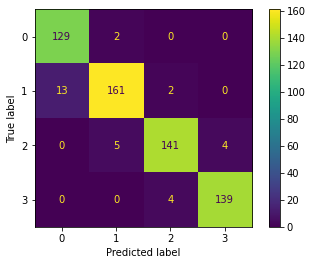

In [91]:
cm  = confusion_matrix(y_test, pred_y)
cmp = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3])

cmp.plot()

#? Note:  0 is often confused as 1
#?        1 is confused as 2
#?        2 is confused as 3
#?  This makes sense because close price range may be easily confused.......i guess (i don't know)

In [96]:
#let's check which sample like to get wrong, especially "0 is often confused as 1"
conda = pred_y == 0
condb = y_test == 1

X_test[conda & condb]  
#so i will leave at that....but if you are the domain expert, you can check here....
 

array([[-0.66024757, -0.16664437, -0.69963176, -0.90180308],
       [-1.15147758,  0.96812008, -0.11120173,  0.18434547],
       [-0.55654346,  0.06758557, -0.82764899, -1.31458566],
       [-0.84127493,  1.15686848, -1.29255364, -1.24309817],
       [-0.97317928, -0.77154886,  1.65184247,  0.48874379],
       [-0.48103959, -1.17633458,  0.04152057, -0.59971081],
       [-0.83308776,  0.1244375 , -0.09772623, -0.34143345],
       [-0.68026065, -1.24455689, -0.60081145,  1.61409515],
       [-0.73120302, -1.16041604,  1.10159301, -0.01858675],
       [-0.46648462, -0.98758618,  0.01456958, -0.87182446],
       [-0.86310737,  1.05453501, -1.20945474, -0.36449393],
       [-0.72119648, -1.38100151,  0.9061983 ,  0.6386369 ],
       [-0.82581028,  1.10229063, -0.52669622, -1.40913362]])

### Step 7: Feature Importance

In [97]:
grid.best_estimator_.coef_ #(n_classes, n_features)
#n_classes means 0, 1, 2, 3
#if we have only two classes, it will be (1, n_features), because it can 0 or 1

array([[-10.29814315,  -2.53642124,  -1.44852567,  -1.49629286],
       [ -3.22248955,  -0.79978008,  -0.34565953,  -0.5057388 ],
       [  3.31597677,   0.77700278,   0.41109197,   0.47623314],
       [ 10.20465592,   2.55919853,   1.38309323,   1.52579852]])

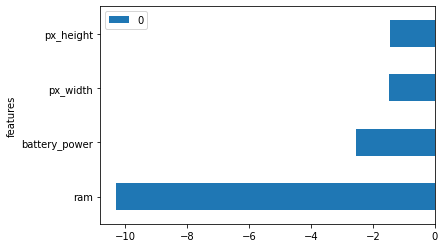

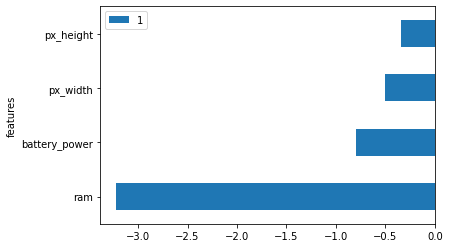

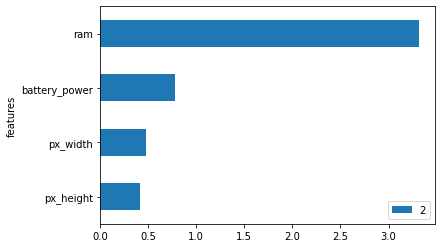

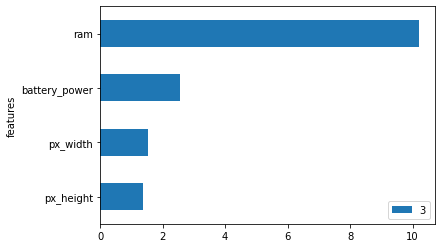

In [98]:
feature_importance = pd.DataFrame(['ram', 'battery_power', 'px_height', 'px_width'], 
                                  columns=['features'])
feature_importance["0"] = grid.best_estimator_.coef_[0]
feature_importance["1"] = grid.best_estimator_.coef_[1]
feature_importance["2"] = grid.best_estimator_.coef_[2]
feature_importance["3"] = grid.best_estimator_.coef_[3]

for _class in ['0', '1', '2', '3']:  
    feature_importance = feature_importance.sort_values(by = [_class], ascending=True)
    feature_importance.plot.barh(x='features', y=_class)
    plt.show()
    
#? What we learn:
#? Class 0:  Ram is most important;  Ram negatively impact the price_range of 0
#? Class 1:  Ram is most important;  Ram negatively impact the price_range of 1
#? Class 2:  Ram is most important;  Ram positively impact the price_range of 2
#? Class 3:  Ram is most important;  Ram positively impact the price_range of 3

#? Overall, all importances point out that ram > battery_power > px_width > px_height

### Step 8: Saving the models